In [9]:
import os
import numpy as np
import pandas as pd
import codecs
import statsmodels.api as sm
from IPython.core.display import HTML, Image
import shlex
import copy
from scipy.stats    import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# Import

- More or less I used your code for the import process. 


- I added a mean value for each error variable that can be defined in the init file such that you are able to play around with it and not only with the standard deviation and the correlations. (I am not sure if this is necessary? Maybe not as useful as I thought in the first moment)


- Furthermore I integrated elements into the 'DIST' key of the imported dictionary that contain all mean, sd and corrcoef s.t. I can use them in the simulation function to simplify the definition process. I am aware of the fact that the loops are messy, maybe it is also not as good as I thought before implementing them.


- Finally I added an element that defines the distribution of the eroor terms ('DIST' 'type')



In [2]:
def import_process(file_):
    '''reads the initialization file and provides an dictionary with parameters for the simulation'''
    dict_={}
    for line in open(file_).readlines():
        
        list_=shlex.split(line)
        
        
        is_empty = (list_ == [])
        
        if not is_empty:
            is_keyword = list_[0].isupper()
        else:
            is_keyword = False


        if is_empty:
            continue
            
        if is_keyword:
            keyword= list_[0]
            dict_[keyword]={}
            continue
        
        if keyword not in ['BENE']:
            _process_not_bene(list_, dict_, keyword)
            
        else:
            _process_in_bene(list_, dict_, keyword)
        
    del dict_['BENE']
    
    # Add auxiliary objects
    dict_ = _add_auxiliary(dict_)
        
    return dict_        

In [3]:
def _process_not_bene(list_, dict_, keyword):
        
    name, val = list_[0], list_[1]


    if name not in dict_[keyword].keys():
        if name in ['coeff']:
            dict_[keyword][name] = []

    # Type conversion
    if name in ['agents', 'maxiter']:
        val = int(val)
    elif name in ['source', 'algorithm', 'start', 'version', 'type']:
        val = str(val)
    else:
        val = float(val)

    # Collect information
    if name in ['coeff']:
        dict_[keyword][name] += [val]
    else:
        dict_[keyword][name] = val

    # Finishing.
    return dict_  

def _process_in_bene(list_, dict_, keyword):
    """ This function processes the BENE part of the initialization file.
    """
    # Distribute information
    name, val_treated, val_untreated = list_[0], list_[1], list_[2]

    # Initialize dictionary
    if 'TREATED' not in dict_.keys():
        for subgroup in ['TREATED', 'UNTREATED']:
            dict_[subgroup] = {}
            dict_[subgroup]['coeff'] = []
            dict_[subgroup]['int'] = None
            dict_[subgroup]['sd'] = None
            dict_[subgroup]['mean'] = None

    # Type conversion
    val_treated = float(val_treated)
    val_untreated = float(val_untreated)

    # Collect information
    if name in ['coeff']:
        dict_['TREATED'][name] += [val_treated]
        dict_['UNTREATED'][name] += [val_untreated]
    else:
        dict_['TREATED'][name] = val_treated
        dict_['UNTREATED'][name] = val_untreated

    # Finishing
    return dict_

def _add_auxiliary(dict_):
    """ Add some auxiliary objects.
    """
    # Antibugging
    assert (isinstance(dict_, dict))
    # Initialize container
    dict_['AUX'] = {}
    dict_['AUX']['init_values'] = []


    # Full set of coefficients.
    for key_ in ['UNTREATED', 'TREATED', 'COST']:
        dict_[key_]['all'] = [dict_[key_]['int']]ff 
        dict_[key_]['all'] += dict_[key_]['coeff']

        dict_[key_]['all'] = np.array(dict_[key_]['all'])
        
    # Summarize mean and standard deviation parameters in distribution dictionary
    
        for j in dict_[key_].keys():
            for i in ['mean', 'sd']:
                if j.startswith(i):
                    dict_['DIST'][ i + '_' + key_ ] = dict_[key_][j]
                    
    # Combine all mean sd and correaltion parameters in one numpy array for each category  
    for key_ in ['all_rho', 'all_sd', 'all_mean']:
        dict_['DIST'][key_]=[]

    for key_ in sorted(dict_['DIST'].keys()):
        if key_.startswith('rho'):
            dict_['DIST']['all_rho'].append(dict_['DIST'][key_])

        else:
            for j in ['sd', 'mean']:
                if key_.startswith(j):
                    dict_['DIST']['all_' + j].append(dict_['DIST'][key_])
    for key_ in ['all_rho', 'all_sd', 'all_mean']:
        dict_['DIST'][key_]= np.array(dict_['DIST'][key_])
        
                            
    # Delete single mean and sd parameters from 'DIST' dictionary
    # Initiate starting values for correlation coefficients before deleting them from the 'DIST' dictionary
    
    for key_ in ['TREATED', 'UNTREATED', 'COST']:
        
        for i in list(dict_['DIST'].keys()):
                if i.endswith(key_):
                    del dict_['DIST'][i]
                else:
                    if i.startswith('rho'):
                        dict_['AUX']['init_values'] += [dict_['DIST'][i]]
                        del dict_['DIST'][i]
                        

    # Number of covariates
    num_covars_out = len(dict_['TREATED']['all'])
    num_covars_cost = len(dict_['COST']['all'])

    dict_['AUX']['num_covars_out'] = num_covars_out
    dict_['AUX']['num_covars_cost'] = num_covars_cost

    # Number of parameters
    dict_['AUX']['num_paras'] = 2 * num_covars_out + num_covars_cost + 2 + 2

    # Starting values

    for key_ in ['TREATED', 'UNTREATED', 'COST']:
        dict_['AUX']['init_values'] += dict_[key_]['all'].tolist()

    dict_['AUX']['init_values'] += [dict_['TREATED']['sd']]
    dict_['AUX']['init_values'] += [dict_['TREATED']['mean']]

    dict_['AUX']['init_values'] += [dict_['UNTREATED']['sd']]
    dict_['AUX']['init_values'] += [dict_['UNTREATED']['mean']]

    # Finishing
    return dict_

# Simulation process

- I splitted the simulation of the unobservables and the exogeneous variables off from the main simulation function just to equalize the simulation process. Furthermore it provides the opportunity to integrate different options for the distribution of the error terms without touching the main function
    
    
- I changed the computation process of the output and the potential output variables such that it uses matrix notation. But I am not sure if it would create problems in the future. 


- I haven't inserted any test functions or assert statements yet, but I will do it as soon as possible.


- I used your writing function for creating the output file since I am not sure how to improve it or what you want more in this regard. If there is something just tell me.
    

In [4]:
def _simulate_unobservables(dist, covar, vars_, num_agents, means=None):
    """Creates the error term values for each type of error term variable
    """
    if means is None:
        means= np.array([0.]*len(vars_))

    # Create a Covariance matrix
    cov_ = np.diag(vars_)
    
    for i in range(cov_.shape[0]-1):
        cov_[i,cov_.shape[0]-1]= covar[i]
        cov_[cov_.shape[0]-1,i]= covar[i]
    
    
    # Option to integrate case specifications for different distributions 
    
    if dist == 'uniform':
        pass
    
    elif dist == 'normal':
        U = np.random.multivariate_normal(means,cov_, num_agents) 
    
    else:
        pass
                
    return U

def _simulate_outcomes(exog, err, coeff):
    """ Simulates the potential outcomes Y0 and Y1, the resulting
        treatment dummy D and the realized outcome Y """
    
    #Expected values for individuals
    
    exp_y0, exp_y1 = np.dot(coeff[0], exog[0].T), np.dot(coeff[1], exog[0].T)
    
    cost_exp= np.dot(coeff[2], exog[1].T)
    
    # Calculate expected benefit and the resulting treatment dummy
    
    expected_benefits = exp_y1 - exp_y0
    
    cost = cost_exp + err[0:,2]
    
    D=np.array((expected_benefits- cost > 0).astype(float))

    # Realized outcome in both cases for each individual
    
    Y_0, Y_1 = exp_y0 + err[0:,0], exp_y0 + err[0:,1]
    
    # Observed outcomes
    
    Y = D * Y_1 + (1-D) * Y_0
    
    return Y, D, Y_1, Y_0 

def _write_output(end, exog, source, unobserved=False):
    
    if not unobserved:
        np.savetxt(source, np.column_stack((end[0],end[1], exog[0], exog[1] )), delimiter=",", fmt='%8.3f')
    
    else:
        np.savetxt(source, np.column_stack((end[0], end[1], exog[0], exog[1], end[2], end[3])), delimiter=",", fmt='%8.3f')
        


In [5]:
def simulation(init_dict):
    """Main function, defines variables by using the init_dict.
    It creates the endogeneous variables X and Z and relies 
    on the _simulate_outcome and _simulate_unobservables functions
    to simulate the model. Finally it writes an output file by using
    the _write_output function."""
    
    # Ensure recomputability
    np.random.seed(123)
    
    # Distribute information
    num_agents = init_dict['BASICS']['agents']
    source = init_dict['BASICS']['source']

    Y1_coeffs = init_dict['TREATED']['all']
    Y0_coeffs = init_dict['UNTREATED']['all']
    C_coeffs = init_dict['COST']['all']
    coeffs = [Y0_coeffs, Y1_coeffs, C_coeffs]

    V_sd, U1_sd, U0_sd = init_dict['DIST']['all_sd']
    vars_ = [U0_sd**2, U1_sd**2, V_sd**2]
    
    rho = init_dict['DIST']['all_rho']
    
    num_covars_out = Y1_coeffs.shape[0]
    num_covars_cost = C_coeffs.shape[0]

    
    # Simulate observables
    
    means = np.tile(0.0, num_covars_out)
    covs = np.identity(num_covars_out)
    X = np.random.multivariate_normal(means, covs, num_agents)
    
    means = np.tile(0.0, num_covars_out)
    covs = np.identity(num_covars_out)
    Z = np.random.multivariate_normal(means, covs, num_agents)
    
    Z[:,0], X[:,0] = 1.0, 1.0
      
    # Simulate unobservables 
    # Read information about the distribution and the specific means from the init dic
    
    dist= init_dict['DIST']['type']
    means= init_dict['DIST']['all_mean']
    cov_ = np.multiply(init_dict['DIST']['all_sd'][1:],rho) * V_sd

    
    U = _simulate_unobservables(dist, cov_, vars_, num_agents, means)
    
    # Simulate endogeneous variables
    
    Y, D, Y_1, Y_0 = _simulate_outcomes([X, Z], U, coeffs)
     
    # Write output file
    _write_output([Y, D, Y_1, Y_0], [X, Z], source)           

    return Y, Y_1, Y_0, D

# Test run


In [61]:
d = import_process('init.ini')

Y, Y1, Y0, D = simulation(d)

In [62]:
B= Y1 - Y0
ATE = np.mean(B)
TT = np.mean(B[D==1])
TUT =np.mean(B[D==0])

C:\Users\Kartoffel.UNIPC\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


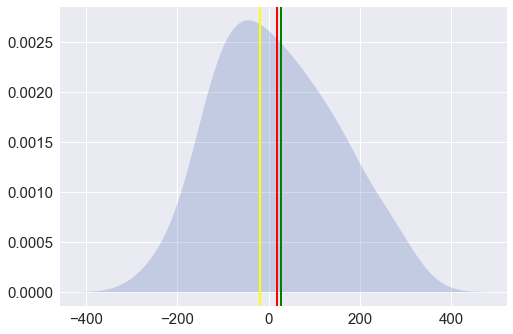

In [63]:
sns.kdeplot(B, shade=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 0.01})
plt.axvline(x=ATE, ymin= 0.0, ymax= 1, linewidth=2, c='red')
plt.axvline(x=TT, ymin= 0.0, ymax= 1, linewidth=2, c='green')
plt.axvline(x=TUT, ymin= 0.0, ymax= 1, linewidth=2, c='yellow')


In [64]:
print('ATE=', ATE, '\nTT=', TT, '\nTUT=', TUT)

ATE= 18.0944912923 
TT= 27.827315657 
TUT= -18.5194670324


In [81]:
# correlated unifrom distribtuion
rho = 0.5
agents=100000
share_corr = rho *agents
share_uncorr = agents - share_corr 

In [94]:
np.random.seed()
U1= np.random.uniform(.0, 1., share_corr )
U2= np.random.uniform(.0, 1., share_uncorr)
U3 = np.random.uniform(.0,1., share_uncorr)

U, V = U1+U2, U1+U3

C:\Users\Kartoffel.UNIPC\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Users\Kartoffel.UNIPC\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
C:\Users\Kartoffel.UNIPC\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [110]:
V = np.random.uniform(0.0,1.0, 1000)
print(len(V[465:]))                      

535


In [207]:
def _correlated_uniform_distribution(var_, cov, num_agents):
    
    corr=np.zeros(len(cov))
    for i in range(len(cov)):
        corr[i] = cov[i] / ((var_[i] * var_[2])**0.5)
    print(corr)
    #share of correlation
    share_corr = [ int(i * num_agents) for i in corr ]
    share_uncorr = [ num_agents - i for i in share_corr ]
    print(share_corr)
    print(share_uncorr)
    
    V = np.array(np.random.uniform(0.0,1.0,size=num_agents))
    #
    Error_uncorr = [0]*len(corr)
    for i in range(len(corr)):
        Error_uncorr[i] = np.random.uniform(0.0,1.0, share_uncorr[i])
    Errors=[0]*len(corr)
    for i in range(len(corr)):
            if i == 0:
                Errors[i] = np.append(Error_uncorr[i],V[:share_corr[i]])
            else:
                Errors[i] =np.append(Error_uncorr[i], V[share_uncorr[i]:])
    return Errors, V
            
        
        
    
    

In [204]:
1/12

0.08333333333333333

In [205]:
cov = [0.0416, 0.0208]
Var = [0.083, 0.083, 0.083]
num_agents= 100

In [208]:
U, V= _correlated_uniform_distribution(Var, cov, num_agents)

[ 0.50120482  0.25060241]
[50, 25]
[50, 75]


In [211]:
np.corrcoef(U[0], V)

array([[ 1.        ,  0.15293468],
       [ 0.15293468,  1.        ]])

In [138]:
 
corr=np.zeros(len(cov))
for i in range(len(cov)):
    print(i)
    corr[i] = cov[i] / Var[i]

0
1


In [151]:
Error_uncorr = [0]*len(corr)
for i in range(len(corr)):
    print(i)
    Error_uncorr[i] = np.random.uniform(0.0,1.0, share_uncorr)

0
1


C:\Users\Kartoffel.UNIPC\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [152]:
print(Error_uncorr)

[array([ 0.891958  ,  0.41464534,  0.0175855 , ...,  0.6261032 ,
        0.25997724,  0.67833236]), array([ 0.09826451,  0.317491  ,  0.3967169 , ...,  0.50852959,
        0.73501616,  0.03028198])]


In [150]:
print(len(corr))

2
